In [1]:
# Offical code for the paper Multi-task Learning for Newspaper Image Segmentation and Baseline Detection Using Attention-Based U-Net Architecture
# This Notebook is divided into follwoing parts

# Data Proeprocssing
# Multi-Task Attention U-Net
# Visualizing Attention Maps
# Testing

In [ ]:
"""
Importing Libraries needed for the project
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import tensorflow.keras.backend as K
from skimage.transform import resize
from tqdm import tqdm
import sys

In [ ]:
# images_path = #Path to images folder
# baseline_masks_path =  #Path to Baselines_Masks Folder
# textblock_masks_path = #Path to Texblock_Masks Folder
# images = os.listdir(images_path)
# baseline_masks = os.listdir(baseline_masks_path)
# textblock_masks = os.listdir(textblock_masks_path)

# Dataset Preprocessing

In [ ]:
# CSV file containing Image Names, Baseline Mask Names, Textblock Mask Names
dataset = pd.read_csv('drive/MyDrive/Train Data/train_data.csv') 
dataset.head()

In [ ]:
channels = 3
height = 1024
width =  1024

In [ ]:
def make_slices(dataset,image_path,mask_path):
    """
    Used to generate image slices
    Input: CSV file for dataset, image folder path, mask folder path
    Output: Slices for image and basline stored named folders for each image and baseline
    """
    #Folders to store the Image/Mask slices
    os.mkdir("drive/MyDrive/Train Data/image_slices/")
    os.mkdir("drive/MyDrive/Train Data/mask_slices/")

    sys.stdout.flush()
    for i in tqdm(range(train_length),total=train_length):

        image_name, mask_name = dataset.iloc[i]

        img = cv2.imread(image_path + image_name)
        mask = cv2.imread(mask_path + mask_name)

        # Making Named folders to store Image/Baseline Masks in the slices folder
        os.mkdir("drive/MyDrive/Train Data/image_slices/{}".format(image_name)) 
        os.mkdir("drive/MyDrive/Train Data/mask_slices/{}".format(mask_name))

        #Resizing the original image of shape (I_h, I_w, _) to (n_w * 1024,n_h * 1024, _) to make slices of shape (1024, 1024, _)
        h, w, _ = img.shape

        n_h = h // 1024
        n_w = w // 1024

        img_resize = cv2.resize(img,(n_w * 1024,n_h * 1024),cv2.INTER_AREA)
        mask_resize = cv2.resize(mask,(n_w * 1024,n_h * 1024),cv2.INTER_AREA)

        win_h = 1024
        win_w = 1024

        count = 0 
        #Storing the slices to their corresponding named folders
        for j in range(n_h):
            for i in range(n_w):
                slice_img = img_resize[win_h*j:win_h*j+win_h,win_w*i:win_w*i+win_w,:]
                cv2.imwrite(f"drive/MyDrive/Train Data/image_slices/{image_name}/slice_{count}.jpg",slice_img)

                slice_mask = mask_resize[win_h*j:win_h*j+win_h,win_w*i:win_w*i+win_w,:]
                cv2.imwrite(f"drive/MyDrive/Train Data/mask_slices/{mask_name}/slice_{count}.jpg",slice_mask)

        count += 1 

In [ ]:
#Call the function for baseline and textblock
make_slices(dataset,images_path,mask_path)

In [ ]:
# img_slices_path = #Path to image_slices
# textblock_mask_slices_path = # Path to textblock mask slices
# baseline_mask_slices_path = # Path to baseline mask slices

In [ ]:
# function to caluate total number of slices i.e, length of train set
def get_count(path):
    dir_list = os.listdir(path)
    count = 0
    for dir in dir_list:
        count += len(os.listdir(path + dir))
    return count 

In [4]:
train_length = get_count(img_slices_path)
train_length

In [3]:
def image_generator(dataset,images_path,masks1_path,masks2_path,train_length,img_shape):
    """
    Data generator to process in the U-Net
    input: dataset CSV file, paths to images/masks, train_length, shape of image
    output : X_train, Y1_train(Textblock), Y2_train(Baseline) numpy arrays of shape (train_length, height, width, _)

    """
    
    height,width,channels = img_shape
    X_train = np.zeros((train_length, height, width, channels), dtype=np.uint8)
    Y1_train = np.zeros((train_length, height, width, 1), dtype=np.float32)
    Y2_train = np.zeros((train_length, height, width, 1), dtype=np.float32)
    count = 0
    sys.stdout.flush()

    for n in tqdm(range(len(dataset)), total=len(dataset)):

        image_name, mask_name = dataset.iloc[n]
        image_path = images_path + image_name + "/"
        mask1_path = masks1_path + mask_name + "/"
        mask2_path = masks2_path + mask_name + "/"
    
        for image, mask in zip(sorted(os.listdir(image_path)),sorted(os.listdir(mask1_path))):
            print(count)
            img = cv2.imread(image_path + image)[:,:,:channels]
            X_train[count] = img

            mask1 = cv2.imread(mask1_path + mask)[:,:,:1]
            Y1_train[count] = mask1


            mask2 = cv2.imread(mask2_path + mask)[:,:,:1]
            Y2_train[count] = mask2
            count += 1

    return X_train,Y1_train,Y2_train

In [3]:
X_train,Y1_train,Y2_train = image_generator(dataset,img_slices_path,textblock_mask_slices_path,baseline_mask_slices_path,train_length,(height,width,channels))

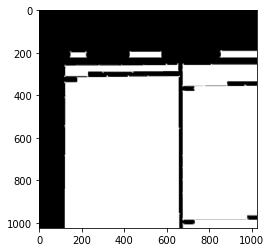

In [ ]:
#Textblock slice sample from Y1_train
plt.imshow(Y1_train[0].squeeze(),cmap="gray")

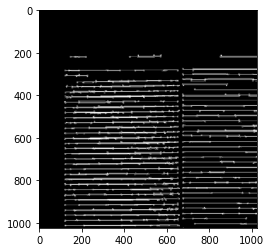

In [ ]:
#Baseline slice sample from Y2_train
plt.imshow(Y2_train[0].squeeze(),cmap="gray")

## Defining Metrics

In [ ]:
def dice_coef(y_true,y_pred,epsilon=0.001):
    #Dice loss helps in determining the overlap between predicted and the actual mask
    y_true_sum  = K.sum(y_true)
    y_pred_sum  = K.sum(y_pred)
    intersection = K.sum(y_true * y_pred)
    return ((2 * intersection + epsilon)/(y_true_sum + y_pred_sum + epsilon))

def dice_coef_loss(y_true,y_pred):
    # loss fucntion 
    return  1 - dice_coef(y_true,y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Multi-Task Attenion U-net

In [2]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, concatenate, Add, Multiply
from tensorflow.keras.layers import Activation, BatchNormalization

In [3]:
def attention_block(x, g, inter_shape,layer_no):
    #Gated attention block used in skip connections in the U-Net
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=1,
                   strides=1,
                   padding='same')(g)

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=(shape_x[1] // shape_g[1],
                              shape_x[2] // shape_g[2]),
                     padding='same')(x)

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1],
                                             shape_x[2] //
                                             shape_sigmoid[2]))(psi)


    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=shape_x[3],
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization(name=f"Attention_Block_{layer_no}")(output)
    return output

In [4]:
def unet(input_size=(1024,1024,3)):
    """
    The multitask attention U-net for Basline detection and Text Block Segmentation
    input : img_shape (1024, 1024, 3) i.e, slice 
    output: U-Net
    """
    inputs = Input(input_size,name = "Main_Input")
    x = Lambda(lambda x: x / 255)(inputs)
    
    #Contracting Path
    down_block_0_layer_0 = Conv2D(16,kernel_size=(3,3),padding="same")(x)
    down_block_0_layer_0 = Activation("relu")(down_block_0_layer_0)
    down_block_0_layer_1 = Conv2D(16,kernel_size=(3,3),padding='same')(down_block_0_layer_0)
    down_block_0_layer_1 = BatchNormalization(axis=3)(down_block_0_layer_1)
    down_block_0_layer_1 = Activation("relu")(down_block_0_layer_1)
    down_block_0_pool = MaxPool2D((2,2),strides=(2,2))(down_block_0_layer_1)
    
    down_block_1_layer_0 = Conv2D(32,kernel_size=(3,3),padding="same")(down_block_0_pool)
    down_block_1_layer_0 = Activation("relu")(down_block_1_layer_0)
    down_block_1_layer_1 = Conv2D(32,kernel_size=(3,3),padding='same')(down_block_1_layer_0)
    down_block_1_layer_1 = BatchNormalization(axis=3)(down_block_1_layer_1)
    down_block_1_layer_1 = Activation("relu")(down_block_1_layer_1)
    down_block_1_pool = MaxPool2D((2,2),strides=(2,2))(down_block_1_layer_1)
    
    down_block_2_layer_0 = Conv2D(64,kernel_size=(3,3),padding="same")(down_block_1_pool)
    down_block_2_layer_0 = Activation("relu")(down_block_2_layer_0)
    down_block_2_layer_1 = Conv2D(64,kernel_size=(3,3),padding='same')(down_block_2_layer_0)
    down_block_2_layer_1 = BatchNormalization(axis=3)(down_block_2_layer_1)
    down_block_2_layer_1 = Activation("relu")(down_block_2_layer_1)
    down_block_2_pool = MaxPool2D((2,2),strides=(2,2))(down_block_2_layer_1)
    
    down_block_3_layer_0 = Conv2D(128,kernel_size=(3,3),padding="same")(down_block_2_pool)
    down_block_3_layer_0 = Activation("relu")(down_block_3_layer_0)
    down_block_3_layer_1 = Conv2D(128,kernel_size=(3,3),padding='same')(down_block_3_layer_0)
    down_block_3_layer_1 = BatchNormalization(axis=3)(down_block_3_layer_1)
    down_block_3_layer_1 = Activation("relu")(down_block_3_layer_1)
    down_block_3_pool = MaxPool2D((2,2),strides=(2,2))(down_block_3_layer_1)
    
    down_block_4_layer_0 = Conv2D(256,kernel_size=(3,3),padding="same")(down_block_3_pool)
    down_block_4_layer_0 = Activation("relu")(down_block_4_layer_0)
    down_block_4_layer_1 = Conv2D(256,kernel_size=(3,3),padding='same')(down_block_4_layer_0)
    down_block_4_layer_1 = BatchNormalization(axis=3)(down_block_4_layer_1)
    down_block_4_layer_1 = Activation("relu")(down_block_4_layer_1)
    
    #Expanding Path
    up_block_0_upsample =  UpSampling2D((2,2))(down_block_4_layer_1)
    attention_0 = attention_block(up_block_0_upsample,down_block_3_layer_1,128,0)
    concat_block_0 =  concatenate([up_block_0_upsample,attention_0],axis=3)
    up_block_0_layer_0 = Conv2D(128,kernel_size=(3,3),padding="same")(concat_block_0)
    up_block_0_layer_0 = Activation("relu")(up_block_0_layer_0)
    up_block_0_layer_1 = Conv2D(128,kernel_size=(3,3),padding='same')(up_block_0_layer_0)
    up_block_0_layer_1 = BatchNormalization(axis=3)(up_block_0_layer_1)
    up_block_0_layer_1 = Activation("relu")(up_block_0_layer_1)
    
    up_block_1_upsample =  UpSampling2D((2,2))(up_block_0_layer_1)
    attention_1 = attention_block(up_block_1_upsample,down_block_2_layer_1,64,1)
    concat_block_1 =  concatenate([up_block_1_upsample,attention_1],axis=3)
    up_block_1_layer_0 = Conv2D(64,kernel_size=(3,3),padding="same")(concat_block_1)
    up_block_1_layer_0 = Activation("relu")(up_block_1_layer_0)
    up_block_1_layer_1 = Conv2D(64,kernel_size=(3,3),padding='same')(up_block_1_layer_0)
    up_block_1_layer_1 = BatchNormalization(axis=3)(up_block_1_layer_1)
    up_block_1_layer_1 = Activation("relu")(up_block_1_layer_1)
    
    up_block_2_upsample =  UpSampling2D((2,2))(up_block_1_layer_1)
    attention_2 = attention_block(up_block_2_upsample,down_block_1_layer_1,32,2)
    concat_block_2 =  concatenate([up_block_2_upsample,attention_2],axis=3)
    up_block_2_layer_0 = Conv2D(32,kernel_size=(3,3),padding="same")(concat_block_2)
    up_block_2_layer_0 = Activation("relu")(up_block_2_layer_0)
    up_block_2_layer_1 = Conv2D(32,kernel_size=(3,3),padding='same')(up_block_2_layer_0)
    up_block_2_layer_1 = BatchNormalization(axis=3)(up_block_2_layer_1)
    up_block_2_layer_1 = Activation("relu")(up_block_2_layer_1)
    
    up_block_3_upsample =  UpSampling2D((2,2))(up_block_2_layer_1)
    attention_3 = attention_block(up_block_3_upsample,down_block_0_layer_1,16,3)
    concat_block_3 =  concatenate([up_block_3_upsample,attention_3],axis=3)
    up_block_3_layer_0 = Conv2D(16,kernel_size=(3,3),padding="same")(concat_block_3)
    up_block_3_layer_0 = Activation("relu")(up_block_3_layer_0)
    up_block_3_layer_1 = Conv2D(16,kernel_size=(3,3),padding='same')(up_block_3_layer_0)
    up_block_3_layer_1 = BatchNormalization(axis=3)(up_block_3_layer_1)
    up_block_3_layer_1 = Activation("relu")(up_block_3_layer_1)
        
    # Two branches predrcting basline and textblock masks respectively
    baseline_branch = Conv2D(1,(1,1),activation="sigmoid",name="baseline_output")(up_block_3_layer_1)
    textblock_branch = Conv2D(1,(1,1),activation="sigmoid",name="textblock_output")(up_block_3_layer_1)

    
    return Model(inputs = [inputs], outputs = [textblock_branch,baseline_branch])

In [5]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Main_Input (InputLayer)         [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1024, 1024, 3 0           Main_Input[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 1024, 1024, 1 448         lambda[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 1024, 1024, 1 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
#hyperparameters
epochs = 300
batch_size = 2
learning_rate = 1e-4

In [ ]:
# Creating a Directory to setup checkpoints
os.mkdir(os.getcwd() + "/drive/MyDrive/Train Data/Models/Checkpoints_Slices_BN_1024_Attention_MultiTask/")

## Model Training Setup

In [6]:

class Callback(tf.keras.callbacks.Callback):#Callback set to monitor model loss
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('loss') < 0.2):
            print("Model loss reached, so stop training!!")
            self.model.stop_training = True 

checkpoint_path = os.getcwd() +"/drive/MyDrive/Train Data/Models/Checkpoints_Slices_BN_1024_Attention_MultiTask/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, #Checkpoint set to save the best weights with min val_loss
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             save_weights_only = True,
                             verbose=1,
                             save_freq = 'epoch')

callback = Callback()

model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
#optimizers for both branches
opt2 = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
opt1 = tf.keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False,decay = decay_rate)

In [2]:
#Training the Model
model.compile(optimizer=opt1,loss={"textblock_output":dice_coef_loss,"baseline_output":dice_coef_loss},loss_weights={"textblock_output":10,"baseline_output":1},metrics=[dice_coef,'accuracy',f1_m,precision_m, recall_m])
results_2 = model.fit({"Main_Input":X_train},{"textblock_output":Y1_train,"baseline_output":Y2_train},validation_split=0.2,batch_size=batch_size, epochs=epochs,callbacks=[checkpoint,callback])

## Visualizing Attention Maps

In [ ]:
def generate_heatmap(model,img,layer_no):
    """
    Generates attention maps for the attention block at some level in the U-Net
    input: model, image, layer_no
    output: attention map of the attebtion block at the corresponding layer
    """

    attn_layer_model = Model(inputs = model.input, outputs = model.get_layer("Attention_Block_{}".format(layer_no)).output)
    attn_model = tf.keras.models.Sequential()
    attn_model.add(attn_layer_model)
    attn_model.add(Conv2D(1,(1,1),activation="sigmoid"))

    img_test = img.reshape((1,1024,1024,3)).astype(np.uint8)
    heatmap = attn_model.predict(img_test)

    heatmap = cv2.resize(heatmap.squeeze(),(1024,1024))
    heatmap = np.uint8(255 * heatmap)
    heatmap_ = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(heatmap_, 0.4, img_slice.astype(heatmap.dtype), 0.6, 0)
    superimposed_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    superimposed_img = np.uint8(superimposed_img)
    superimposed_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)

    return superimposed_img

In [ ]:
def draw_attention_maps(model,img):
    """
    Produces attention maps for every attention block in the U-Net
    input: model, image
    output: plot of attention maps for the U-Net
    """
    plt.figure(figsize=(16,4))
    plt.subplot(141)
    plt.imshow(img,cmap="gray")
    plt.title("Image")
    for i in range(3):
        plt.subplot(int(f"14{i+1}"))
        heatmap = generate_heatmap(model,img,i)
        plt.title(f"Attention_Block_{i}")
    plt.suptitle('Attention Heatmaps')

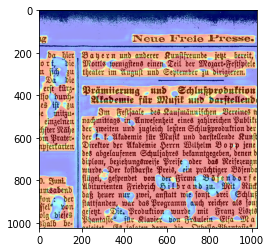

In [ ]:
# plt.imshow(superimposed_img)

## Training Results

In [ ]:
test_path ="/content/drive/MyDrive/Train Data/test_data/test_images"

In [ ]:
img = plt.imread("/content/drive/MyDrive/Train Data/test_data/test_images/ONB_nfp_19110701_012.jpg")[:,:,:channels]
img_slice = img[1024:2048,1024:2048]
img_test = img_slice.reshape((1,height,width,channels)).astype(np.uint8)
pred1,pred2 = model.predict(img_test)
pred1 = (pred1 > 0.5).astype(np.uint8)
pred2 = (pred2 > 0.5).astype(np.uint8)

Text(0.5, 0.98, 'Model')

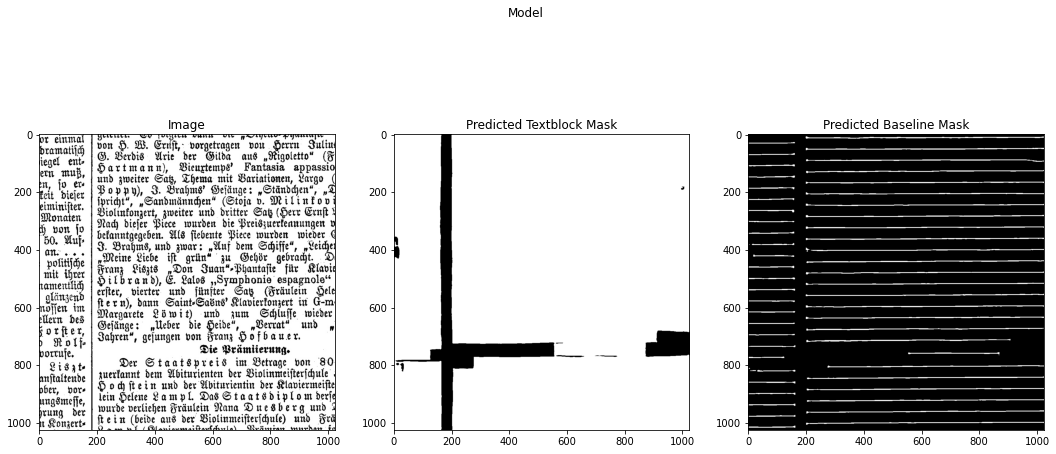

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(131)
plt.imshow(img_slice.squeeze(),cmap='gray')
plt.title('Image')
plt.subplot(132)
plt.imshow(pred1.squeeze(),cmap='gray')
plt.title('Predicted Textblock Mask')
plt.subplot(133)
plt.imshow(pred2.squeeze(),cmap='gray')
plt.title('Predicted Baseline Mask')
plt.suptitle('Model')
# plt.savefig( os.getcwd() + "/drive/MyDrive/Train Data/BN_204811.jpg")

In [ ]:
loss_2 = results_2.history['loss']
dice_coeff_2 = results_2.history['dice_coef']
accuracy_2 = results_2.history['accuracy']
val_loss_2 = results_2.history['val_loss']
val_dice_coeff_2 = results_2.history['val_dice_coef']
val_accuracy_2 = results_2.history['val_accuracy']

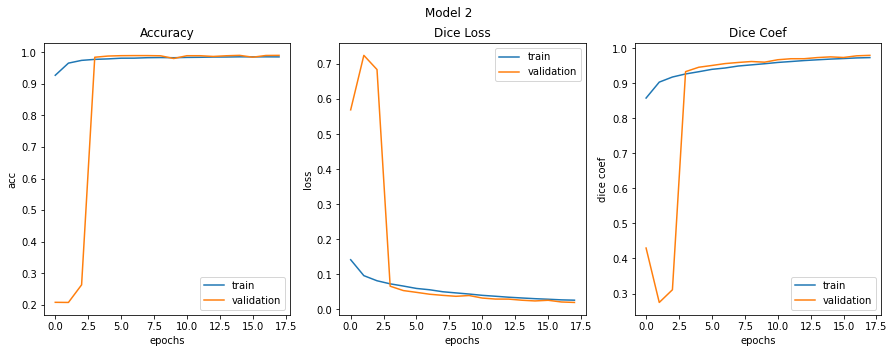

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(accuracy_2,label='training accuracy')
plt.plot(val_accuracy_2,label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['train','validation'])
plt.title('Accuracy')
plt.subplot(132)
plt.plot(loss_2,label='training loss')
plt.plot(val_loss_2,label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'])
plt.title('Dice Loss')
plt.subplot(133)
plt.plot(dice_coeff_2,label='training dice coef')
plt.plot(val_dice_coeff_2,label='validation dice coef')
plt.xlabel('epochs')
plt.ylabel('dice coef')
plt.legend(['train','validation'])
plt.title('Dice Coef')
plt.suptitle('Model 2')
plt.savefig( os.getcwd() + "/drive/MyDrive/Train Data/model2.jpg")

# **Testing the Model**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import tensorflow.keras.backend as K
import sys
from tqdm import  tqdm
from skimage.transform import resize

In [10]:
dataset_path = "/content/drive/MyDrive/Train Data/test_data/"
mask_path1 = dataset_path + "test_masks1/"
mask_path2 = dataset_path + "test_masks2/"
image_path = dataset_path + "test_images/"
img_shape = (1024,1024,3)

In [ ]:
images = os.listdir(image_path)
masks1  = os.listdir(mask_path1)
masks2  = os.listdir(mask_path2)
images.sort()
masks1.sort()
masks2.sort()
test_set = pd.DataFrame({'images': np.array(images),'masks1':np.array(masks1),'masks2':np.array(masks1)})

In [ ]:
test_set

,images,masks1,masks2
0,ONB_nfp_19110701_012.jpg,Mask_ONB_nfp_19110701_012.jpg,Mask_ONB_nfp_19110701_012.jpg
1,ONB_nfp_19110701_013.jpg,Mask_ONB_nfp_19110701_013.jpg,Mask_ONB_nfp_19110701_013.jpg
2,ONB_nfp_19110701_014.jpg,Mask_ONB_nfp_19110701_014.jpg,Mask_ONB_nfp_19110701_014.jpg
3,ONB_nfp_19110701_015.jpg,Mask_ONB_nfp_19110701_015.jpg,Mask_ONB_nfp_19110701_015.jpg
4,ONB_nfp_19330701_012.jpg,Mask_ONB_nfp_19330701_012.jpg,Mask_ONB_nfp_19330701_012.jpg


In [6]:
def dice_coef(y_true,y_pred,epsilon=0.001):
    y_true_sum  = K.sum(y_true)
    y_pred_sum  = K.sum(y_pred)
    intersection = K.sum(y_true * y_pred)
    return ((2 * intersection + epsilon)/(y_true_sum + y_pred_sum + epsilon))

def dice_coef_loss(y_true,y_pred):
    return  1 - dice_coef(y_true,y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

opt = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [7]:
def test_results(images,masks,model):
  #function to generate predicted baseline and texblock mask for the given image slice
    for image,mask in zip(images,masks):
        image = image.reshape(1,1024,1024,3)
        mask_pred = model.predict(image)
        mask_pred = (mask_pred > 0.5).astype(np.uint8)

        plt.figure(figsize=(24,20))
        plt.subplot(131)
        plt.imshow(image.squeeze())
        plt.title("Text Document")
        plt.subplot(132)
        plt.imshow(mask.squeeze(),cmap='gray')
        plt.title("Original Mask")
        plt.subplot(133)
        plt.imshow(mask_pred.squeeze(),cmap='gray')
        plt.title('Predicted Mask')
        plt.show()

In [8]:
#Loading the best saved weights for model testing
checkpoint_path = os.getcwd() +"/drive/MyDrive/Train Data/Models/Checkpoints_Slices_BN_1024_Attention_MultiTask/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest_weights = tf.train.latest_checkpoint(checkpoint_dir)
model = unet(input_size=img_shape)
model.load_weights(latest_weights)
model.compile(optimizer=opt,loss={"textblock_output":dice_coef_loss,"baseline_output":dice_coef_loss},metrics=[dice_coef,'accuracy',f1_m,precision_m, recall_m])

In [ ]:
def test_generator(dataset,image_path,mask1_path,mask2_path,train_length,img_shape):
    #similar to the train generator
    height,width,channels = img_shape
    X_test = []
    Y1_test = []
    Y2_test = []
    sys.stdout.flush()
    for n in tqdm(range(train_length), total=train_length):

        image_name, mask1_name, mask2_name = dataset.iloc[n]
        img = cv2.imread(image_path + image_name)[:,:,:channels]
        mask1 = cv2.imread(mask1_path + mask1_name)[:,:,:1]
        mask2 = cv2.imread(mask2_path + mask2_name)[:,:,:1]
        h, w, _ = img.shape

        n_h = h // 1024
        n_w = w // 1024    
        img_resize = cv2.resize(img,(n_w * 1024,n_h * 1024),cv2.INTER_AREA)
        mask1_resize = cv2.resize(mask1,(n_w * 1024,n_h * 1024),cv2.INTER_AREA)
        mask2_resize = cv2.resize(mask2,(n_w * 1024,n_h * 1024),cv2.INTER_AREA)

        win_h = 1024
        win_w = 1024

        for j in range(n_h):
            for i in range(n_w):
                img_slice = img_resize[win_h*j:win_h*j+win_h,win_w*i:win_w*i+win_h]
                mask_slice1 = mask1_resize[win_h*j:win_h*j+win_h,win_w*i:win_w*i+win_h]
                mask_slice2 = mask2_resize[win_h*j:win_h*j+win_h,win_w*i:win_w*i+win_h]
                X_test.append(img_slice)
                Y1_test.append(mask_slice1)
                Y2_test.append(mask_slice2)

    X_test = np.array(X_test).astype(np.uint8)
    Y1_test = np.array(Y1_test).astype(np.bool)
    Y2_test = np.array(Y2_test).astype(np.bool)
    return X_test, Y1_test, Y2_test

In [ ]:
X_test, Y1_test,Y2_test = test_generator(test_set,image_path,mask_path1,mask_path2,len(images),img_shape)
Y1_test = Y1_test.astype(np.float32)
Y2_test = Y2_test.astype(np.float32)

100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


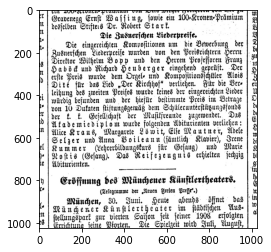

In [ ]:
plt.imshow(X_test[10])

In [ ]:
results = model.evaluate({"Main_Input":X_test},{"textblock_output":Y1_test,"baseline_output":Y2_test},batch_size=2)

38/38 [==============================] - 46s 225ms/step - loss: 0.3245 - textblock_output_loss: 0.0067 - baseline_output_loss: 0.3178 - textblock_output_dice_coef: 0.9933 - textblock_output_accuracy: 0.9900 - textblock_output_f1_m: 0.9933 - textblock_output_precision_m: 0.9923 - textblock_output_recall_m: 0.9943 - baseline_output_dice_coef: 0.6822 - baseline_output_accuracy: 0.9565 - baseline_output_f1_m: 0.6827 - baseline_output_precision_m: 0.6546 - baseline_output_recall_m: 0.7145


### Random testing on image

In [ ]:
dataset_path = "/content/drive/MyDrive/Train Data/simple_pages_test/"
images_path = dataset_path + "images/"

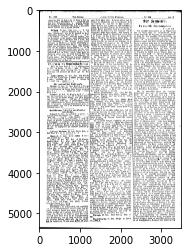

In [ ]:
plt.imshow(img)

In [ ]:
def testing(img):
    """
    Predicting the complete baseline and textblokc mask for the given test image
    input : test image
    output: baseline mask, text block mask
    """
  #resizing the test image to obtain slices
    h, w, _ = img.shape
    n_h = h // 1024
    n_w = w // 1024    
    img_resize = cv2.resize(img,(n_w * 1024,n_h * 1024),cv2.INTER_AREA)
    win_h = 1024
    win_w = 1024
    for j in range(n_h):
        for i in range(n_w):
        #making the prediction on slices
            img_slice = img_resize[win_h*j:win_h*j+win_h,win_w*i:win_w*i+win_h]
            img_slice_pred = img_slice.reshape(1,1024,1024,3)
            mask_slice1,mask_slice2 = model.predict(img_slice_pred)
            mask_slice1 = (mask_slice1 > 0.5).astype(np.uint8).reshape(1024,1024)
            mask_slice2 = (mask_slice2 > 0.5).astype(np.uint8).reshape(1024,1024)
            plt.subplot(121)
            plt.imshow(mask_slice1,cmap='gray')
            plt.subplot(122)
            plt.imshow(mask_slice2,cmap='gray')
            plt.show()
    #concatenating the predicted slices to obatin full mask 
    if (i==0):
        slice_1 = mask_slice1
        slice_2 = mask_slice2
    else:
        slice_1 = cv2.hconcat([slice_1,mask_slice1])
        slice_2 = cv2.hconcat([slice_2,mask_slice2])
    if (j==0):
        f_img1 = slice_1
        f_img2 = slice_2
    else:
        f_img1 = cv2.vconcat([f_img1,slice_1])
        f_img2 = cv2.vconcat([f_img2,slice_2])
    return f_img1,f_img2

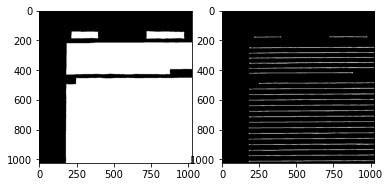

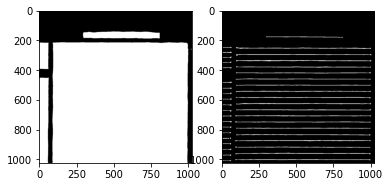

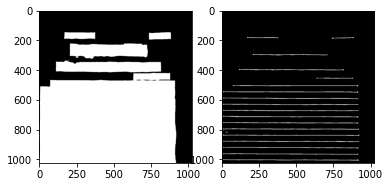

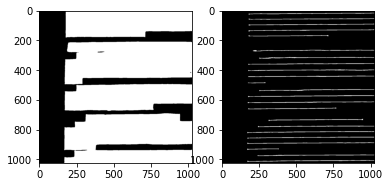

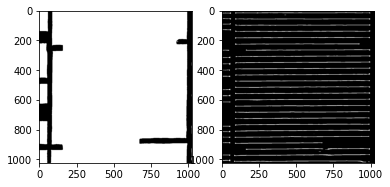

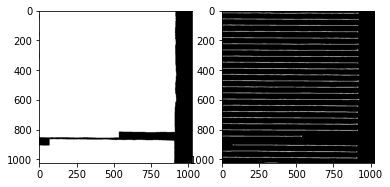

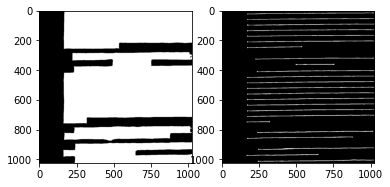

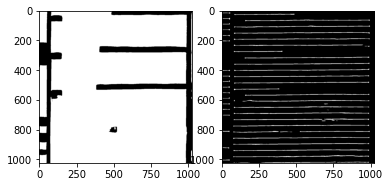

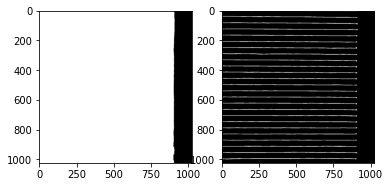

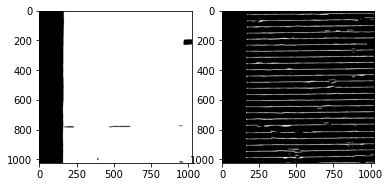

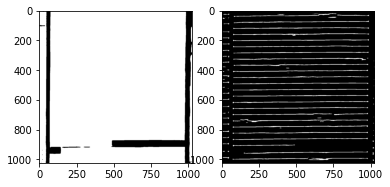

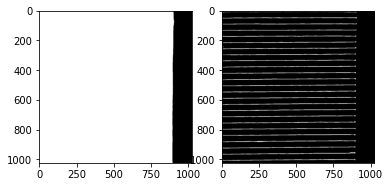

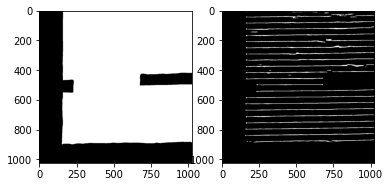

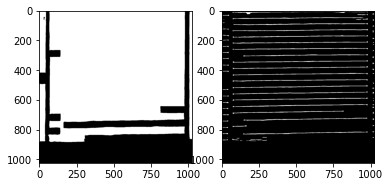

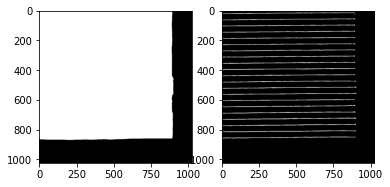

In [ ]:
final_result1,final_result2 = testing(img)

Text(0.5, 0.98, 'Pred')

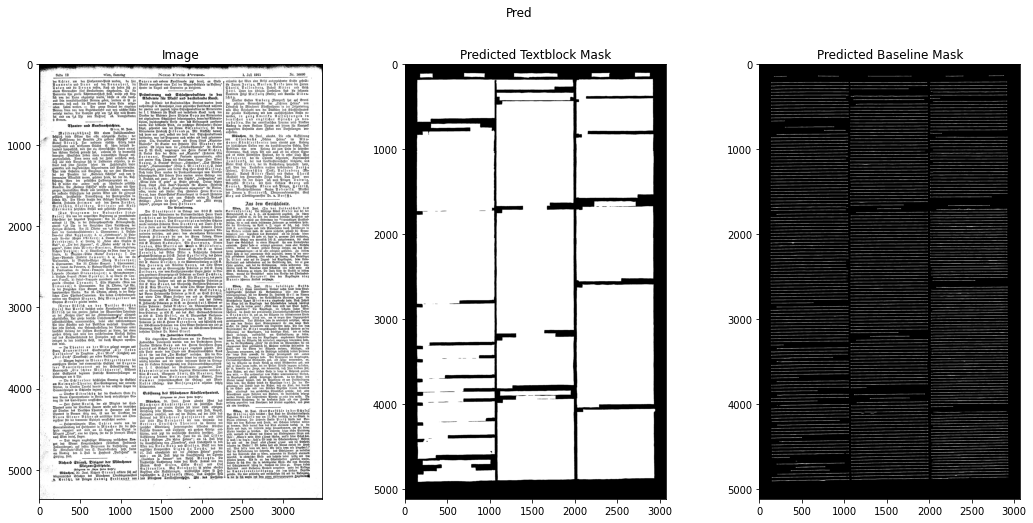

In [ ]:
plt.figure(figsize=(18,8))
plt.subplot(131)
plt.imshow(img.astype(np.uint8),cmap='gray')
plt.title('Image')
plt.subplot(132)
plt.imshow(final_result1.squeeze(),cmap='gray')
plt.title('Predicted Textblock Mask')
plt.subplot(133)
plt.imshow(final_result2.squeeze(),cmap='gray')
plt.title('Predicted Baseline Mask')
plt.suptitle('Pred')
# plt.savefig("/content/drive/MyDrive/Train Data/test.jpg")